# Movie Recommendation System

In [2]:
import pandas as pd
import numpy as np
import math
import pickle
import os
import re
import json
import http.client

import time
import sys
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import BaggingClassifier
from sklearn.feature_selection import chi2, mutual_info_classif

## Functions

### Models

In [2]:
# Binarize genres, tags

def tokenize_string(my_string):
    return re.findall('[\w\-\.]+', my_string.lower())

def tokenize(movies):
    movies['tokens'] = [tokenize_string(mg) for mg in movies['genres']]
    return movies

def tokenize_tag(movies):
    toks = []
    for idx, row in movies.iterrows():
        try:
            tag = tags.query('movieId=='+str(row['movieId'])).iloc[0]['tag']
            for t in tag:
                t = t.lower();
                t = t.replace('-','')
                t = t.replace('/','')
                if len(t) > 0:
                    if t[0] == '#':
                        temp = t.split(' ')
                        for te in temp:
                            row['tokens'] = list(set(row['tokens'] + [str(te[1:])]))
                    else:
                        if len(t) > 0:
                            temp = tokenize_string(t)
                            temp2 = ''
                            for te in range(len(temp)):
                                temp2 += temp[te]
                            
                            if not temp2.isdigit():
                                if not temp2 == '':
                                    row['tokens'] = list(set(row['tokens'] + [str(temp2)]))
        except:
            a = 1 #filler
        toks += [row['tokens']]
    movies['n_tokens'] = toks
    return movies

def feature(movies, docs):
    temp = [t for mt in movies['n_tokens'] for t in mt if len(mt) > 0 ]
    tokens = Counter(temp)
    t = {}
    i = 0
    for k, v in tokens.items():
        if v > docs:
            t[k] = (v,i) 
            i += 1
    with open('data/vocab.json', 'w') as fp:
        json.dump(t, fp)

def featurize(movies, movie_rating, vocab):
    tokens = movies.query('movieId=='+str(movie_rating[0])).reset_index()
    temp = []
    token = []
    for idx, row in tokens.iterrows():
        token = row['n_tokens']
        break
    for k in vocab.keys():
        if(k in token):
            temp += [1]
        else:
            temp += [0]
    return temp

def target(threshold, movie_rating):
    if movie_rating[1] >= threshold:
        return 1
    else:
        return 0

def user_movies(users, user):
    movieId = users.query('userId=='+str(user))['movieId'].tolist()
    ratings = users.query('userId=='+str(user))['rating'].tolist()
    return list(zip(movieId, ratings))

def read_vocab(filename):
    with open('data/'+filename, 'r') as fp:
        data = json.load(fp)
    return data

def read_csv(filename):
    return pd.read_csv(filename)

def sorted_users(users, position):
    temp = users.groupby(['userId']).size().sort_values(ascending=False).reset_index()
    return temp.loc[position,'userId'], temp.loc[position, 0]
    
def X_y(threshold, movie_rating, movies, vocab):
    X = []
    y = []
    for mr in movie_rating:
        X += [featurize(movies, mr, vocab)]
        y += [target(threshold, mr)]
    return np.array(X), np.array(y)

def recommend_model(model, X, y, movie_rating, left, movies, vocab, threshold, limit):
    if model == 'NBT':
        clf = BernoulliNB(alpha=1e-10, fit_prior=True)
    elif model == 'NBF':
        clf = BernoulliNB(alpha=1e-10, fit_prior=False)
    elif model == 'LR':
        clf = LogisticRegression(solver='liblinear')
    elif model == 'LRL1':
        clf = LogisticRegression(solver='liblinear', penalty='l1')
    elif model == 'LRL2':
        clf = LogisticRegression(solver='liblinear', penalty='l2')
    else:
        return 'input correct model'
    X_train, y_train = X_y(threshold, movie_rating, movies, vocab)
    clf.fit(X_train, y_train)
    X_test = []
    for mr in range(limit):
        if left[mr] > limit:
            break
        else:
            X_test += [featurize(movies, (left[mr],'?'), vocab)]
    pred = clf.predict_proba(np.array(X_test))
    recod = []
    for p in range(len(pred)):
        recod += [(left[p], pred[p][1])]
    return recod, clf

### Content Based

In [3]:
# Content-Based

def cb_featurize(movies, vocab):
    N = len(movies['movieId'])
    features = []
    for mt in movies['n_tokens']:
        temp = [0 for l in range(len(vocab))]
        max_k_tf = 0
        for t in Counter(mt).items():
            if(t[1] > max_k_tf):
                max_k_tf = t[1]
        for t in Counter(mt).items():
            if(t[0] in vocab.keys()):
                tf = t[1]
                df = vocab[t[0]][0]
                temp[vocab[t[0]][1]] = tf/max_k_tf * np.log10(N/df)
        features += csr_matrix(temp)
    
    movies['features'] = features
    return movies

def cosine_sim(a, b):
    return np.dot(a.toarray()[0],b.toarray()[0])/ (np.linalg.norm(a.toarray()[0]) * np.linalg.norm(b.toarray()[0]))

def make_predictions(movies, left, movie_rating, limit):
    lst = []
    i = 0
    for pm in left:
        a = movies[movies['movieId'] == pm]['features'].tolist()[0]
        train = []
        weights = []
        for mr in movie_rating:
            b = movies[movies['movieId'] == mr[0]]['features'].tolist()[0]
            weight =  cosine_sim(a,b)
            if weight > 0:
                train += [weight*mr[1]]
                weights += [weight]
        if len(train) > 0:
            rating = sum(train)/sum(weights)
            lst += [(pm,rating)]
        print(i,len(left),rating)
        if rating >= limit:
            break
        i += 1
    return lst

### Collaborative Filtering

In [4]:
# Collaborative Filtering

def colab_matrix(users, movie_ids):
    colab_ma = [[0 for x in range(len(users.groupby(['userId']).size()))] for y in range(movie_ids)]
    for mi in range(1,movie_ids+1):
        print(mi)
        temp = users[users['movieId'] == mi]
        for idx, row in temp.iterrows():
            colab_ma[mi-1][int(row['userId'])-1] = row['rating']
    file = 'Recommenders/Collaborative/colab_matrix'+'.pickle'
    with open(file, 'wb') as handle:
        pickle.dump(colab_ma, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def pearson_sim(r1,r2):
    m1 = np.mean(r1[np.where(r1 != 0)])
    m2 = np.mean(r2[np.where(r2 != 0)])
    overlap = [i for i in range(len(r1)) if r1[i] != 0 and r2[i] != 0]
    numerator = ((r1[overlap] - m1) * (r2[overlap] - m2))
    numerator = numerator.sum()
    denominator = (  math.sqrt(((r1[overlap] - m1)**2).sum()) 
                   * math.sqrt(((r2[overlap] - m2)**2).sum())  )
    return numerator/ denominator

def ratings(user, limit):
    movie_rating = []
    file = 'Recommenders/Collaborative/colab_matrix'+'.pickle'
    with open(file, 'rb') as handle:
        colab_ma = pickle.load(handle)
    print('Starting')
    for movies in range(limit):
        ratings = []
        sims = []
        if (colab_ma[movies][user - 1] == 0):
            for movies1 in range(len(colab_ma)):
                rating = colab_ma[movies1][user - 1]
                if not (rating == 0):
                    sim = pearson_sim(np.array(colab_ma[movies]),np.array(colab_ma[movies1]))
                    if sim > 0:
                        ratings += [sim*rating]
                        sims += [sim]
        if len(ratings) > 0:
            rat = sum(ratings)/sum(sims)
            movie_rating += [(movies+1,rat)]
            print(movies+1,rat)
    return movie_rating

def update_rating(user, movie, movie_ids, rating):
    with open(file, 'rb') as handle:
        colab_ma = pickle.load(handle)
    colab_ma[movie_ids.index(movie)][user-1] = rating
    with open(file, 'wb') as handle:
        pickle.dump(np.array(colab_ma), handle, protocol=pickle.HIGHEST_PROTOCOL)
            

### Evidence

In [209]:
def evidence_matrix(X, w):
    """Given a data matrix X and a weight array w, compute and return evidence matrix."""
    A = np.array(X)
    return A*w

def evidence_array(M):
    """Given an evidence matrix M, calculate an evidence array."""
    A = np.array(M)
    lst = []
    for a in A:
        pos = 0
        neg = 0
        for r in a:
            if r > 0:
                pos += r
            else:
                neg += r
        lst += [[neg, pos]]
    return np.array(lst)

In [61]:
#importing the data files onto dataframes
path = 'ml-latest'
users = read_csv(path + os.path.sep + 'ratings.csv')
#movies = read_csv(path + os.path.sep + 'movies.csv')
tags = read_csv(path + os.path.sep + 'tags.csv')
#tmdb = pd.read_csv(path + os.path.sep + 'links.csv')
tags = tags.groupby('movieId')['tag'].apply(list).reset_index()
vocab = read_vocab('vocab.json')
movies = pd.read_pickle("data/update.pkl")

## Research Active Learning

In [8]:
user, count = sorted_users(users, 2780)

In [9]:
count

1000

In [10]:
user

138483

In [11]:
used = users[users['userId'] == user]['movieId'].tolist()
left = movies[~movies['movieId'].isin(used)]['movieId'].tolist()

In [12]:
threshold = 4

In [13]:
movie_rating = user_movies(users, user)

In [14]:
X, y = X_y(threshold, movie_rating, movies, vocab)

In [15]:
Counter(y)

Counter({1: 519, 0: 481})

In [16]:
type(X)

numpy.ndarray

In [93]:
X_pool, X_test, y_pool, y_test = train_test_split(X, y, random_state=42, test_size=1/3)

### Logistic Regression / Naive Bayes

In [95]:
# Active Learning

def random_sampling(d, accuracy, precision, recall, f1):
    rs_cands = candidates.copy()
    rs_tis = train_indices.copy()
    for i in range(budget):
        c = rand.randint(len(rs_cands))
        rs_tis.append(rs_cands[c])
        rs_cands = rs_cands[:c] + rs_cands[c+1:]
        clf = BernoulliNB(alpha=alpha, fit_prior=False)
        clf.fit(X_pool[rs_tis], y_pool[rs_tis])
        y_test_predict = clf.predict(X_test)
        a = accuracy_score(y_test, y_test_predict)
        accuracy += [a]
        precision += [precision_score(y_test, y_test_predict)]
        recall += [recall_score(y_test, y_test_predict)]
        f1 += [f1_score(y_test, y_test_predict)]
        print('rs',i, len(rs_cands), a)
    d['random_sampling'] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'rs_tis':len(rs_tis)}
    return d
    
def uncertainty_sampling(d, accuracy, precision, recall, f1):
    unc_cands = candidates.copy()
    unc_tis = train_indices.copy()
    clf = BernoulliNB(alpha=alpha, fit_prior=False)
    clf.fit(X_pool[unc_tis], y_pool[unc_tis])
    for i in range(budget):
        probs = clf.predict_proba(X_pool[unc_cands])
        c = np.argmin(np.max(probs, axis=1))
        unc_tis.append(unc_cands[c])
        unc_cands = unc_cands[:c] + unc_cands[c+1:]
        clf = BernoulliNB(alpha=alpha, fit_prior=False)
        clf.fit(X_pool[unc_tis], y_pool[unc_tis])
        y_test_predict = clf.predict(X_test)
        a = accuracy_score(y_test, y_test_predict)
        accuracy += [a]
        precision += [precision_score(y_test, y_test_predict)]
        recall += [recall_score(y_test, y_test_predict)]
        f1 += [f1_score(y_test, y_test_predict)]
        print('us',i, len(unc_cands), a)
    d['uncertainty_sampling'] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'unc_tis':len(unc_tis)}
    return d
    
def query_by_bagging(d, accuracy, precision, recall, f1):
    bag_cands = candidates.copy()
    bag_tis = train_indices.copy()
    for i in range(budget):
        print('qb',i, len(bag_cands))
        base_clf = BernoulliNB(alpha=alpha, fit_prior=False)
        bag_clf = BaggingClassifier(base_estimator=base_clf, max_samples=1.0, max_features=0.50, bootstrap=False, bootstrap_features=False)
        bag_clf.fit(X_pool[bag_tis], y_pool[bag_tis])
        probs = bag_clf.predict_proba(X_pool[bag_cands])
        c = np.argmin(np.max(probs, axis=1))
        bag_tis.append(bag_cands[c])
        bag_cands = bag_cands[:c] + bag_cands[c+1:]
        clf = BernoulliNB(alpha=alpha, fit_prior=False)
        clf.fit(X_pool[bag_tis], y_pool[bag_tis])
        y_test_predict = clf.predict(X_test)
        a = accuracy_score(y_test, y_test_predict)
        accuracy += [a]
        precision += [precision_score(y_test, y_test_predict)]
        recall += [recall_score(y_test, y_test_predict)]
        f1 += [f1_score(y_test, y_test_predict)]
        print('qb',i, len(bag_cands), a)
    d['query_by_bagging'] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'bag_tis':len(bag_tis)}
    return d

# Active Learning with user 10532 and 4 threshold
d = {}
seed = 42
rand = np.random.RandomState(seed)
train_indices = []
candidates = list(rand.permutation(X_pool.shape[0]))
for j in range(len(candidates)):
    train_indices.append(candidates[j])
    if len(np.unique(y_pool[train_indices])) == 2:
        candidates = candidates[j+1:]
        break
d['L'] = len(train_indices)
budget = len(candidates)
alpha = 1e-10
clf = BernoulliNB(alpha=alpha, fit_prior=False)
clf.fit(X_pool[train_indices], y_pool[train_indices])
y_test_predict = clf.predict(X_test)
initial_accuracy = accuracy_score(y_test, y_test_predict)
initial_precision = precision_score(y_test, y_test_predict)
initial_recall = recall_score(y_test, y_test_predict)
initial_f1 = f1_score(y_test, y_test_predict)
simulations = [random_sampling, uncertainty_sampling, query_by_bagging]
for s in simulations:
    d = s(d,[initial_accuracy],[initial_precision],[initial_recall],[initial_f1])

rs 0 662 0.5299401197604791
rs 1 661 0.5419161676646707
rs 2 660 0.5329341317365269
rs 3 659 0.5359281437125748
rs 4 658 0.5419161676646707
rs 5 657 0.5119760479041916
rs 6 656 0.5329341317365269
rs 7 655 0.5389221556886228
rs 8 654 0.5449101796407185
rs 9 653 0.5958083832335329
rs 10 652 0.5958083832335329
rs 11 651 0.592814371257485
rs 12 650 0.5718562874251497
rs 13 649 0.562874251497006
rs 14 648 0.562874251497006
rs 15 647 0.562874251497006
rs 16 646 0.5688622754491018
rs 17 645 0.5718562874251497
rs 18 644 0.5658682634730539
rs 19 643 0.5778443113772455
rs 20 642 0.5808383233532934
rs 21 641 0.5898203592814372
rs 22 640 0.5898203592814372
rs 23 639 0.5958083832335329
rs 24 638 0.6047904191616766
rs 25 637 0.6107784431137725
rs 26 636 0.6287425149700598
rs 27 635 0.6137724550898204
rs 28 634 0.6077844311377245
rs 29 633 0.5988023952095808
rs 30 632 0.6047904191616766
rs 31 631 0.5958083832335329
rs 32 630 0.6317365269461078
rs 33 629 0.6347305389221557
rs 34 628 0.6317365269461078

rs 279 383 0.5688622754491018
rs 280 382 0.5658682634730539
rs 281 381 0.5748502994011976
rs 282 380 0.5808383233532934
rs 283 379 0.5808383233532934
rs 284 378 0.5838323353293413
rs 285 377 0.5838323353293413
rs 286 376 0.5808383233532934
rs 287 375 0.5808383233532934
rs 288 374 0.5838323353293413
rs 289 373 0.5808383233532934
rs 290 372 0.5808383233532934
rs 291 371 0.5838323353293413
rs 292 370 0.5808383233532934
rs 293 369 0.5808383233532934
rs 294 368 0.5778443113772455
rs 295 367 0.5778443113772455
rs 296 366 0.5778443113772455
rs 297 365 0.5778443113772455
rs 298 364 0.5778443113772455
rs 299 363 0.5778443113772455
rs 300 362 0.5748502994011976
rs 301 361 0.5838323353293413
rs 302 360 0.5838323353293413
rs 303 359 0.5838323353293413
rs 304 358 0.5868263473053892
rs 305 357 0.5898203592814372
rs 306 356 0.5868263473053892
rs 307 355 0.5898203592814372
rs 308 354 0.5868263473053892
rs 309 353 0.5988023952095808
rs 310 352 0.5958083832335329
rs 311 351 0.592814371257485
rs 312 350 

rs 554 108 0.6107784431137725
rs 555 107 0.6107784431137725
rs 556 106 0.6107784431137725
rs 557 105 0.6107784431137725
rs 558 104 0.6107784431137725
rs 559 103 0.6167664670658682
rs 560 102 0.6167664670658682
rs 561 101 0.6197604790419161
rs 562 100 0.6227544910179641
rs 563 99 0.6227544910179641
rs 564 98 0.6227544910179641
rs 565 97 0.625748502994012
rs 566 96 0.625748502994012
rs 567 95 0.625748502994012
rs 568 94 0.625748502994012
rs 569 93 0.6287425149700598
rs 570 92 0.6287425149700598
rs 571 91 0.6287425149700598
rs 572 90 0.6287425149700598
rs 573 89 0.6317365269461078
rs 574 88 0.6287425149700598
rs 575 87 0.6287425149700598
rs 576 86 0.6287425149700598
rs 577 85 0.6287425149700598
rs 578 84 0.6287425149700598
rs 579 83 0.625748502994012
rs 580 82 0.6317365269461078
rs 581 81 0.6377245508982036
rs 582 80 0.6377245508982036
rs 583 79 0.6377245508982036
rs 584 78 0.6407185628742516
rs 585 77 0.6407185628742516
rs 586 76 0.6407185628742516
rs 587 75 0.6407185628742516
rs 588 74 

us 173 489 0.6077844311377245
us 174 488 0.6047904191616766
us 175 487 0.6047904191616766
us 176 486 0.6047904191616766
us 177 485 0.6017964071856288
us 178 484 0.5958083832335329
us 179 483 0.5958083832335329
us 180 482 0.5958083832335329
us 181 481 0.592814371257485
us 182 480 0.592814371257485
us 183 479 0.5988023952095808
us 184 478 0.5988023952095808
us 185 477 0.5988023952095808
us 186 476 0.6017964071856288
us 187 475 0.6017964071856288
us 188 474 0.6017964071856288
us 189 473 0.6017964071856288
us 190 472 0.6017964071856288
us 191 471 0.5988023952095808
us 192 470 0.5988023952095808
us 193 469 0.5988023952095808
us 194 468 0.592814371257485
us 195 467 0.5988023952095808
us 196 466 0.5988023952095808
us 197 465 0.5958083832335329
us 198 464 0.5958083832335329
us 199 463 0.5868263473053892
us 200 462 0.5868263473053892
us 201 461 0.5898203592814372
us 202 460 0.592814371257485
us 203 459 0.5958083832335329
us 204 458 0.5958083832335329
us 205 457 0.5958083832335329
us 206 456 0.6

us 447 215 0.6377245508982036
us 448 214 0.6377245508982036
us 449 213 0.6467065868263473
us 450 212 0.6467065868263473
us 451 211 0.6467065868263473
us 452 210 0.6467065868263473
us 453 209 0.6437125748502994
us 454 208 0.6437125748502994
us 455 207 0.6437125748502994
us 456 206 0.6407185628742516
us 457 205 0.6437125748502994
us 458 204 0.6437125748502994
us 459 203 0.6407185628742516
us 460 202 0.6407185628742516
us 461 201 0.6407185628742516
us 462 200 0.6407185628742516
us 463 199 0.6407185628742516
us 464 198 0.6407185628742516
us 465 197 0.6407185628742516
us 466 196 0.6407185628742516
us 467 195 0.6407185628742516
us 468 194 0.6407185628742516
us 469 193 0.6407185628742516
us 470 192 0.6407185628742516
us 471 191 0.6407185628742516
us 472 190 0.6437125748502994
us 473 189 0.6437125748502994
us 474 188 0.6437125748502994
us 475 187 0.6437125748502994
us 476 186 0.6437125748502994
us 477 185 0.6437125748502994
us 478 184 0.6437125748502994
us 479 183 0.6437125748502994
us 480 182

qb 48 614 0.5988023952095808
qb 49 614
qb 49 613 0.5958083832335329
qb 50 613
qb 50 612 0.5988023952095808
qb 51 612
qb 51 611 0.6077844311377245
qb 52 611
qb 52 610 0.6107784431137725
qb 53 610
qb 53 609 0.6227544910179641
qb 54 609
qb 54 608 0.6167664670658682
qb 55 608
qb 55 607 0.6137724550898204
qb 56 607
qb 56 606 0.6197604790419161
qb 57 606
qb 57 605 0.6197604790419161
qb 58 605
qb 58 604 0.6107784431137725
qb 59 604
qb 59 603 0.6077844311377245
qb 60 603
qb 60 602 0.6077844311377245
qb 61 602
qb 61 601 0.6077844311377245
qb 62 601
qb 62 600 0.6077844311377245
qb 63 600
qb 63 599 0.6197604790419161
qb 64 599
qb 64 598 0.6227544910179641
qb 65 598
qb 65 597 0.6197604790419161
qb 66 597
qb 66 596 0.6317365269461078
qb 67 596
qb 67 595 0.6287425149700598
qb 68 595
qb 68 594 0.625748502994012
qb 69 594
qb 69 593 0.6167664670658682
qb 70 593
qb 70 592 0.6167664670658682
qb 71 592
qb 71 591 0.6137724550898204
qb 72 591
qb 72 590 0.6197604790419161
qb 73 590
qb 73 589 0.61976047904191

qb 251 411 0.6586826347305389
qb 252 411
qb 252 410 0.655688622754491
qb 253 410
qb 253 409 0.6526946107784432
qb 254 409
qb 254 408 0.6377245508982036
qb 255 408
qb 255 407 0.6377245508982036
qb 256 407
qb 256 406 0.6377245508982036
qb 257 406
qb 257 405 0.6377245508982036
qb 258 405
qb 258 404 0.6377245508982036
qb 259 404
qb 259 403 0.6407185628742516
qb 260 403
qb 260 402 0.6407185628742516
qb 261 402
qb 261 401 0.6437125748502994
qb 262 401
qb 262 400 0.6347305389221557
qb 263 400
qb 263 399 0.6347305389221557
qb 264 399
qb 264 398 0.6347305389221557
qb 265 398
qb 265 397 0.6377245508982036
qb 266 397
qb 266 396 0.6377245508982036
qb 267 396
qb 267 395 0.6347305389221557
qb 268 395
qb 268 394 0.6317365269461078
qb 269 394
qb 269 393 0.6317365269461078
qb 270 393
qb 270 392 0.6317365269461078
qb 271 392
qb 271 391 0.6347305389221557
qb 272 391
qb 272 390 0.6317365269461078
qb 273 390
qb 273 389 0.6377245508982036
qb 274 389
qb 274 388 0.6437125748502994
qb 275 388
qb 275 387 0.6377

qb 452 210 0.6706586826347305
qb 453 210
qb 453 209 0.6706586826347305
qb 454 209
qb 454 208 0.6706586826347305
qb 455 208
qb 455 207 0.6736526946107785
qb 456 207
qb 456 206 0.6706586826347305
qb 457 206
qb 457 205 0.6736526946107785
qb 458 205
qb 458 204 0.6736526946107785
qb 459 204
qb 459 203 0.6706586826347305
qb 460 203
qb 460 202 0.6706586826347305
qb 461 202
qb 461 201 0.6706586826347305
qb 462 201
qb 462 200 0.6706586826347305
qb 463 200
qb 463 199 0.6676646706586826
qb 464 199
qb 464 198 0.6676646706586826
qb 465 198
qb 465 197 0.6676646706586826
qb 466 197
qb 466 196 0.6676646706586826
qb 467 196
qb 467 195 0.6676646706586826
qb 468 195
qb 468 194 0.6676646706586826
qb 469 194
qb 469 193 0.6676646706586826
qb 470 193
qb 470 192 0.6646706586826348
qb 471 192
qb 471 191 0.6646706586826348
qb 472 191
qb 472 190 0.6646706586826348
qb 473 190
qb 473 189 0.6766467065868264
qb 474 189
qb 474 188 0.6766467065868264
qb 475 188
qb 475 187 0.6766467065868264
qb 476 187
qb 476 186 0.676

qb 658 4 0.6227544910179641
qb 659 4
qb 659 3 0.6227544910179641
qb 660 3
qb 660 2 0.6227544910179641
qb 661 2
qb 661 1 0.6227544910179641
qb 662 1
qb 662 0 0.6227544910179641


In [96]:
file = str(user)+'.pickle'
with open(file, 'wb') as handle:
    pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
file = str(user)+'.pickle'
with open(file, 'rb') as handle:
    d_271383 = pickle.load(handle)

In [8]:
import matplotlib.pyplot as plt
from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

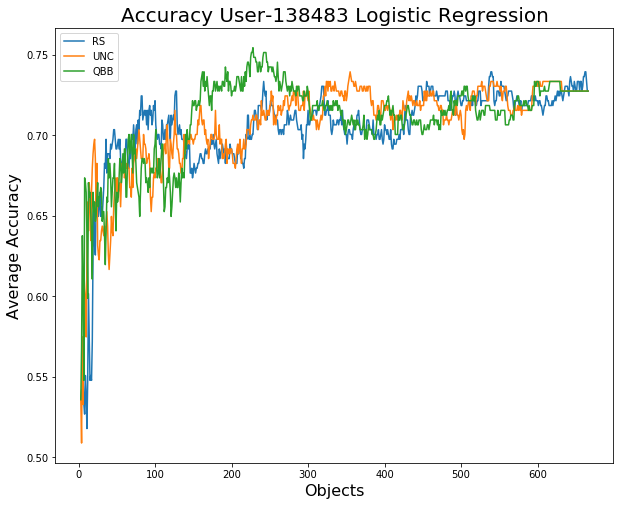

In [9]:
d = d_271383
plt.plot(range(d['L'], d['random_sampling']['rs_tis']+1), d['random_sampling']['accuracy'], label="RS")
plt.plot(range(d['L'], d['uncertainty_sampling']['unc_tis']+1), d['uncertainty_sampling']['accuracy'], label="UNC")
plt.plot(range(d['L'], d['query_by_bagging']['bag_tis']+1), d['query_by_bagging']['accuracy'], label="QBB")
plt.title('Accuracy User-'+str(user)+' Logistic Regression', fontsize=20)
plt.xlabel('Objects', fontsize=16)
plt.ylabel('Average Accuracy', fontsize=16)
plt.legend()
plt.savefig('Accuracy User-'+str(user)+' Logistic Regression.png')

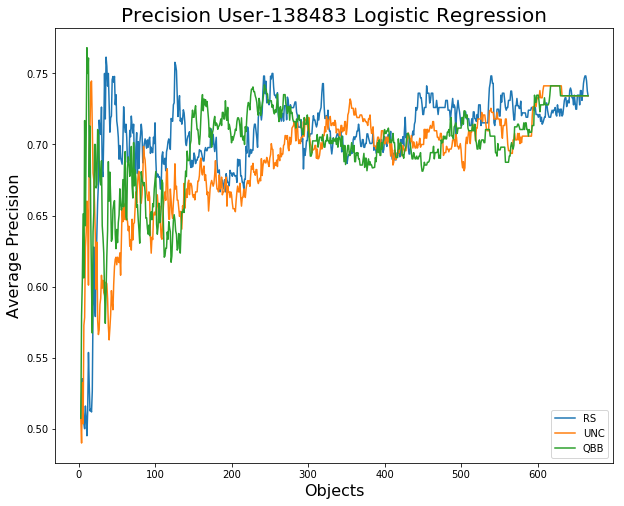

In [10]:
plt.plot(range(d['L'], d['random_sampling']['rs_tis']+1), d['random_sampling']['precision'], label="RS")
plt.plot(range(d['L'], d['uncertainty_sampling']['unc_tis']+1), d['uncertainty_sampling']['precision'], label="UNC")
plt.plot(range(d['L'], d['query_by_bagging']['bag_tis']+1), d['query_by_bagging']['precision'], label="QBB")
plt.title('Precision User-'+str(user)+' Logistic Regression', fontsize=20)
plt.xlabel('Objects', fontsize=16)
plt.ylabel('Average Precision', fontsize=16)
plt.legend()
plt.savefig('Precision User-'+str(user)+' Logistic Regression.png')

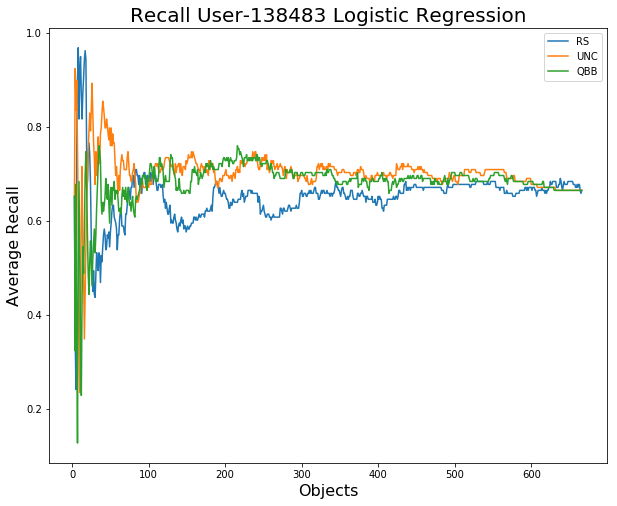

In [11]:
plt.plot(range(d['L'], d['random_sampling']['rs_tis']+1), d['random_sampling']['recall'], label="RS")
plt.plot(range(d['L'], d['uncertainty_sampling']['unc_tis']+1), d['uncertainty_sampling']['recall'], label="UNC")
plt.plot(range(d['L'], d['query_by_bagging']['bag_tis']+1), d['query_by_bagging']['recall'], label="QBB")
plt.title('Recall User-'+str(user)+' Logistic Regression', fontsize=20)
plt.xlabel('Objects', fontsize=16)
plt.ylabel('Average Recall', fontsize=16)
plt.legend()
plt.savefig('Recall User-'+str(user)+' Logistic Regression.png')

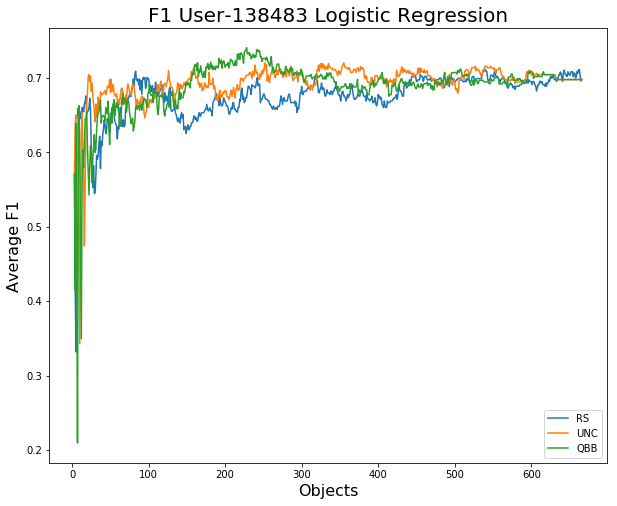

In [12]:
plt.plot(range(d['L'], d['random_sampling']['rs_tis']+1), d['random_sampling']['f1'], label="RS")
plt.plot(range(d['L'], d['uncertainty_sampling']['unc_tis']+1), d['uncertainty_sampling']['f1'], label="UNC")
plt.plot(range(d['L'], d['query_by_bagging']['bag_tis']+1), d['query_by_bagging']['f1'], label="QBB")
plt.title('F1 User-'+str(user)+' Logistic Regression', fontsize=20)
plt.xlabel('Objects', fontsize=16)
plt.ylabel('Average F1', fontsize=16)
plt.legend()
plt.savefig('F1 User-'+str(user)+' Logistic Regression.png')

## Recommending

### Content Based

In [17]:
file = 'Recommenders/Content_Based/'+str(user)+'_cb'

In [18]:
# a = make_predictions(movies, left, movie_rating, threshold)
# with open(file, 'wb') as handle:
#     pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)
# a

In [19]:
with open(file, 'rb') as handle:
    cb_ratings = pickle.load(handle)

In [20]:
cb_ratings = sorted(cb_ratings, key = lambda i: i[1], reverse = True)

In [21]:
# Top x Recommendations w #1 being in threshold
x = 10
print('Rating','\t','Movies')
print('----------------------------------------------------------')
for mov in cb_ratings[:x]:
    print(mov[1].round(2),'\t', movies[movies['movieId'] == mov[0]]['title'].tolist()[0])
limit = cb_ratings[0][0]+1

Rating 	 Movies
----------------------------------------------------------
4.07 	 It Happened One Night (1934)
3.99 	 Across the Sea of Time (1995)
3.97 	 Ballad of Narayama, The (Narayama Bushiko) (1958)
3.95 	 Rear Window (1954)
3.93 	 Touki Bouki (1973)
3.93 	 Brother Minister: The Assassination of Malcolm X (1994)
3.9 	 Force of Evil (1948)
3.89 	 Eyes Without a Face (Yeux sans visage, Les) (1959)
3.88 	 Hippie Revolution, The (1996)
3.86 	 Collector, The (La collectionneuse) (1967)


### Colaborated Filtering

In [182]:
# colab_matrix(users, limit)

In [193]:
# a = ratings(user, limit) ######## Will take time (Will be Done by presentations)

In [186]:
file = 'Recommenders/Collaborative/'+str(user)+'_cF'

In [187]:
# with open(file, 'wb') as handle:
#     pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [188]:
with open(file, 'rb') as handle:
    cf_ratings = pickle.load(handle)

In [189]:
cf_ratings = sorted(cf_ratings, key = lambda i: i[1], reverse = True)

In [190]:
# Top x Recommendations w #1 being in threshold
x = 10
print('Rating','\t','Movies')
print('----------------------------------------------------------')
for mov in cf_ratings[:x]:
    print(mov[1].round(2),'\t', movies[movies['movieId'] == mov[0]]['title'].tolist()[0])

Rating 	 Movies
----------------------------------------------------------
4.03 	 Nueba Yol (1995)
4.01 	 World of Apu, The (Apur Sansar) (1959)
4.0 	 Rear Window (1954)
4.0 	 Honey Moon (Honigmond) (1996)
3.98 	 Vertigo (1958)
3.98 	 Vive L'Amour (Ai qing wan sui) (1994)
3.98 	 Boy Called Hate, A (1995)
3.97 	 Wild Bunch, The (1969)
3.96 	 It Happened One Night (1934)
3.96 	 Beauty of the Day (Belle de jour) (1967)


### Logistic Regression (Model)

#### Base

In [191]:
recom_lg, model_lg = recommend_model('LR', X, y, movie_rating, left, movies, vocab, threshold, limit)

In [192]:
recom_lg = sorted(recom_lg, key = lambda i: i[1], reverse = True)

In [115]:
print('Proba','\t','Movies')
print('----------------------------------------------------------')
error = .5
for mov in recom_lg[:x]:
    if mov[1] > .5:
        print(mov[1].round(2),'\t', movies[movies['movieId'] == mov[0]]['title'].tolist()[0])

Proba 	 Movies
----------------------------------------------------------
1.0 	 Rear Window (1954)
1.0 	 Vertigo (1958)
0.99 	 Three Colors: Blue (Trois couleurs: Bleu) (1993)
0.99 	 Hate (Haine, La) (1995)
0.99 	 Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les) (1964)
0.98 	 Eyes Without a Face (Yeux sans visage, Les) (1959)
0.97 	 Wild Bunch, The (1969)
0.97 	 Song of the Little Road (Pather Panchali) (1955)
0.97 	 Pinocchio (1940)
0.95 	 Sense and Sensibility (1995)


#### L1

In [116]:
recom_lg1, model_lg1 = recommend_model('LRL1', X, y, movie_rating, left, movies, vocab, threshold, limit)

In [117]:
recom_lg1 = sorted(recom_lg1, key = lambda i: i[1], reverse = True)

In [118]:
print('Proba','\t','Movies')
print('----------------------------------------------------------')
error = .5
for mov in recom_lg1[:x]:
    if mov[1] > .5:
        print(mov[1].round(2),'\t', movies[movies['movieId'] == mov[0]]['title'].tolist()[0])

Proba 	 Movies
----------------------------------------------------------
1.0 	 Rear Window (1954)
1.0 	 Vertigo (1958)
0.99 	 Three Colors: Blue (Trois couleurs: Bleu) (1993)
0.99 	 Eyes Without a Face (Yeux sans visage, Les) (1959)
0.97 	 Hate (Haine, La) (1995)
0.97 	 It Happened One Night (1934)
0.97 	 Pinocchio (1940)
0.97 	 Shallow Grave (1994)
0.96 	 Much Ado About Nothing (1993)
0.96 	 Wild Bunch, The (1969)


#### L2

In [119]:
recom_lg2, model_lg2 = recommend_model('LRL2', X, y, movie_rating, left, movies, vocab, threshold, limit)

In [120]:
recom_lg2 = sorted(recom_lg2, key = lambda i: i[1], reverse = True)

In [121]:
print('Proba','\t','Movies')
print('----------------------------------------------------------')
error = .5
for mov in recom_lg2[:x]:
    if mov[1] > .5:
        print(mov[1].round(2),'\t', movies[movies['movieId'] == mov[0]]['title'].tolist()[0])

Proba 	 Movies
----------------------------------------------------------
1.0 	 Rear Window (1954)
1.0 	 Vertigo (1958)
0.99 	 Three Colors: Blue (Trois couleurs: Bleu) (1993)
0.99 	 Hate (Haine, La) (1995)
0.99 	 Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les) (1964)
0.98 	 Eyes Without a Face (Yeux sans visage, Les) (1959)
0.97 	 Wild Bunch, The (1969)
0.97 	 Song of the Little Road (Pather Panchali) (1955)
0.97 	 Pinocchio (1940)
0.95 	 Sense and Sensibility (1995)


### Naive Bayes (Model)

#### Fit Prior = True

In [122]:
recom_nbt, model_nbt = recommend_model('NBT', X, y, movie_rating, left, movies, vocab, threshold, limit)

In [123]:
recom_nbt = sorted(recom_nbt, key = lambda i: i[1], reverse = True)

In [124]:
print('Proba','\t','Movies')
print('----------------------------------------------------------')
error = .5
for mov in recom_nbt[:x]:
    if mov[1] > .5:
        print(mov[1].round(2),'\t', movies[movies['movieId'] == mov[0]]['title'].tolist()[0])

Proba 	 Movies
----------------------------------------------------------
1.0 	 Sense and Sensibility (1995)
1.0 	 Four Rooms (1995)
1.0 	 City of Lost Children, The (Cité des enfants perdus, La) (1995)
1.0 	 Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
1.0 	 Carrington (1995)
1.0 	 Dead Presidents (1995)
1.0 	 From Dusk Till Dawn (1996)
1.0 	 Misérables, Les (1995)
1.0 	 Things to Do in Denver When You're Dead (1995)
1.0 	 Nick of Time (1995)


#### Fit Prior = False

In [125]:
recom_nbf, model_nbf = recommend_model('NBF', X, y, movie_rating, left, movies, vocab, threshold, limit)

In [126]:
recom_nbf = sorted(recom_nbf, key = lambda i: i[1], reverse = True)

In [127]:
print('Proba','\t','Movies')
print('----------------------------------------------------------')
error = .5
for mov in recom_nbf[:x]:
    if mov[1] > .5:
        print(mov[1].round(2),'\t', movies[movies['movieId'] == mov[0]]['title'].tolist()[0])

Proba 	 Movies
----------------------------------------------------------
1.0 	 Sense and Sensibility (1995)
1.0 	 Four Rooms (1995)
1.0 	 City of Lost Children, The (Cité des enfants perdus, La) (1995)
1.0 	 Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
1.0 	 Carrington (1995)
1.0 	 Dead Presidents (1995)
1.0 	 From Dusk Till Dawn (1996)
1.0 	 Misérables, Les (1995)
1.0 	 Things to Do in Denver When You're Dead (1995)
1.0 	 Nick of Time (1995)


## Interaction (Evaluation)

1. Content Based
2. Colaborated Filtering
3. User Interaction

### Content Based

#### Logistic Regression (Base)

In [128]:
movie_shar_lr = []
for j in range(x):
    movie_shar_lr += [cb_ratings[j][0]]
    movie_shar_lr += [recom_lg[j][0]]
temp = []
for k, v in Counter(movie_shar_lr).items():
    if v > 1:
        temp += [k]
movie_shar_lr = temp   

In [129]:
print('Chosen Movies')
print('----------------------------------------------------------')
if(len(movie_shar_lr) == 0):
    print('No Movies')
for i in list(movie_shar_lr):
    print(movies[movies['movieId'] == i]['title'].tolist()[0])

Chosen Movies
----------------------------------------------------------
Rear Window (1954)
Eyes Without a Face (Yeux sans visage, Les) (1959)


#### Logistic Regression (L1)

In [130]:
movie_shar_lr1 = []
for j in range(x):
    movie_shar_lr1 += [cb_ratings[j][0]]
    movie_shar_lr1 += [recom_lg1[j][0]]
temp = []
for k, v in Counter(movie_shar_lr1).items():
    if v > 1:
        temp += [k]
movie_shar_lr1 = temp   

In [131]:
print('Chosen Movies')
if(len(movie_shar_lr1) == 0):
    print('No Movies')
print('----------------------------------------------------------')
for i in list(movie_shar_lr1):
    print(movies[movies['movieId'] == i]['title'].tolist()[0])

Chosen Movies
----------------------------------------------------------
It Happened One Night (1934)
Rear Window (1954)
Eyes Without a Face (Yeux sans visage, Les) (1959)


#### Logistic Regression (L2)

In [132]:
movie_shar_lr2 = []
for j in range(x):
    movie_shar_lr2 += [cb_ratings[j][0]]
    movie_shar_lr2 += [recom_lg2[j][0]]
temp = []
for k, v in Counter(movie_shar_lr2).items():
    if v > 1:
        temp += [k]
movie_shar_lr2 = temp   

In [133]:
print('Chosen Movies')
print('----------------------------------------------------------')
if(len(movie_shar_lr2) == 0):
    print('No Movies')
for i in list(movie_shar_lr2):
    print(movies[movies['movieId'] == i]['title'].tolist()[0])

Chosen Movies
----------------------------------------------------------
Rear Window (1954)
Eyes Without a Face (Yeux sans visage, Les) (1959)


#### Naive Bayes Prior = T

In [134]:
movie_shar_nbt = []
for j in range(x):
    movie_shar_nbt += [cb_ratings[j][0]]
    movie_shar_nbt += [recom_nbt[j][0]]
temp = []
for k, v in Counter(movie_shar_nbt).items():
    if v > 1:
        temp += [k]
movie_shar_nbt = temp   

In [135]:
print('Chosen Movies')
print('----------------------------------------------------------')
if(len(movie_shar_nbt) == 0):
    print('No Movies')
for i in list(movie_shar_nbt):
    print(movies[movies['movieId'] == i]['title'].tolist()[0])

Chosen Movies
----------------------------------------------------------
No Movies


#### Naive Bayes Prior = F

In [136]:
movie_shar_nbf = []
for j in range(x):
    movie_shar_nbf += [cb_ratings[j][0]]
    movie_shar_nbf += [recom_nbf[j][0]]
temp = []
for k, v in Counter(movie_shar_nbf).items():
    if v > 1:
        temp += [k]
movie_shar_nbf = temp   

In [137]:
print('Chosen Movies')
print('----------------------------------------------------------')
if(len(movie_shar_nbf) == 0):
    print('No Movies')
for i in list(movie_shar_nbf):
    print(movies[movies['movieId'] == i]['title'].tolist()[0])

Chosen Movies
----------------------------------------------------------
No Movies


### Collaborative Filtering (Need to Finish)

#### Logistic Regression (Base)

In [194]:
movie_shar_lr = []
for j in range(x):
    movie_shar_lr += [cf_ratings[j][0]]
    movie_shar_lr += [recom_lg[j][0]]
temp = []
for k, v in Counter(movie_shar_lr).items():
    if v > 1:
        temp += [k]
movie_shar_lr = temp   

In [195]:
print('Chosen Movies')
print('----------------------------------------------------------')
if(len(movie_shar_lr) == 0):
    print('No Movies')
for i in list(movie_shar_lr):
    print(movies[movies['movieId'] == i]['title'].tolist()[0])

Chosen Movies
----------------------------------------------------------
Rear Window (1954)
Vertigo (1958)
Wild Bunch, The (1969)


#### Logistic Regression (L1)

In [196]:
movie_shar_lr1 = []
for j in range(x):
    movie_shar_lr1 += [cf_ratings[j][0]]
    movie_shar_lr1 += [recom_lg1[j][0]]
temp = []
for k, v in Counter(movie_shar_lr1).items():
    if v > 1:
        temp += [k]
movie_shar_lr1 = temp

In [197]:
print('Chosen Movies')
if(len(movie_shar_lr1) == 0):
    print('No Movies')
print('----------------------------------------------------------')
for i in list(movie_shar_lr1):
    print(movies[movies['movieId'] == i]['title'].tolist()[0])

Chosen Movies
----------------------------------------------------------
Rear Window (1954)
Vertigo (1958)
It Happened One Night (1934)
Wild Bunch, The (1969)


#### Logistic Regression (L2)

In [198]:
movie_shar_lr2 = []
for j in range(x):
    movie_shar_lr2 += [cf_ratings[j][0]]
    movie_shar_lr2 += [recom_lg2[j][0]]
temp = []
for k, v in Counter(movie_shar_lr2).items():
    if v > 1:
        temp += [k]
movie_shar_lr2 = temp   

In [199]:
print('Chosen Movies')
print('----------------------------------------------------------')
if(len(movie_shar_lr2) == 0):
    print('No Movies')
for i in list(movie_shar_lr2):
    print(movies[movies['movieId'] == i]['title'].tolist()[0])

Chosen Movies
----------------------------------------------------------
Rear Window (1954)
Vertigo (1958)
Wild Bunch, The (1969)


#### Naive Bayes Prior = T

In [200]:
movie_shar_nbt = []
for j in range(x):
    movie_shar_nbt += [cf_ratings[j][0]]
    movie_shar_nbt += [recom_nbt[j][0]]
temp = []
for k, v in Counter(movie_shar_nbt).items():
    if v > 1:
        temp += [k]
movie_shar_nbt = temp   

In [201]:
print('Chosen Movies')
print('----------------------------------------------------------')
if(len(movie_shar_nbt) == 0):
    print('No Movies')
for i in list(movie_shar_nbt):
    print(movies[movies['movieId'] == i]['title'].tolist()[0])

Chosen Movies
----------------------------------------------------------
No Movies


#### Naive Bayes Prior = F

In [202]:
movie_shar_nbf = []
for j in range(x):
    movie_shar_nbf += [cf_ratings[j][0]]
    movie_shar_nbf += [recom_nbf[j][0]]
temp = []
for k, v in Counter(movie_shar_nbf).items():
    if v > 1:
        temp += [k]
movie_shar_nbf = temp   

In [203]:
print('Chosen Movies')
print('----------------------------------------------------------')
if(len(movie_shar_nbf) == 0):
    print('No Movies')
for i in list(movie_shar_nbf):
    print(movies[movies['movieId'] == i]['title'].tolist()[0])

Chosen Movies
----------------------------------------------------------
No Movies


### Interaction & Evidence

In [210]:
## Only Lg Example

In [211]:
X_test = []
for mr in range(limit):
    if left[mr] > limit:
        break
    else:
        X_test += [featurize(movies, (left[mr],'?'), vocab)]
w = model_lg.coef_[0]
em = evidence_matrix(X_test,w)
ea = evidence_array(em)

In [215]:
print('Here are the top 10 recomendations for now')
additions = []
for rl in range(x):
    print(str(rl+1)+'.',movies[movies['movieId'] == recom_lg[rl][0]]['title'].tolist()[0])
    print('Negative Evidence:',ea[left.index(recom_lg[rl][0])][0],'Positive Evidence:',ea[left.index(recom_lg[rl][0])][1])
    while True:
        inp = input('What would you rate this movie? Out of 5. Input enter to skip')
        if(inp.isdigit()):
            additions += [recom_lg[rl][0], float(inp)]
            break
        elif inp == '':
            break
        else:
            print("Please enter a digit")
            

Here are the top 10 recomendations for now
1. Rear Window (1954)
Negative Evidence: -2.1188104440126714 Positive Evidence: 12.836065464852425
What would you rate this movie? Out of 5. Input enter to skip
2. Vertigo (1958)
Negative Evidence: -4.839411599316044 Positive Evidence: 12.463522929912937
What would you rate this movie? Out of 5. Input enter to skip
3. Three Colors: Blue (Trois couleurs: Bleu) (1993)
Negative Evidence: -2.232796304506745 Positive Evidence: 8.597366563355775
What would you rate this movie? Out of 5. Input enter to skip
4. Hate (Haine, La) (1995)
Negative Evidence: -2.914122191968339 Positive Evidence: 8.632242199041727
What would you rate this movie? Out of 5. Input enter to skip
5. Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les) (1964)
Negative Evidence: -2.395208823398853 Positive Evidence: 7.956075777354768
What would you rate this movie? Out of 5. Input enter to skip
6. Eyes Without a Face (Yeux sans visage, Les) (1959)
Negative Evidence: -1.14386

# Transparency

In [141]:
vocab_idx = {}
for k,v in vocab.items():
    vocab_idx[str(v[1])] = k

## Feature Importance

### Logistic Regression (Base)

In [143]:
coef_ml = [abs(ml) for ml in model_lg.coef_[0]]
coef_ml_idx = np.unravel_index(np.argsort(coef_ml, axis=None), np.array(coef_ml).shape)
print('#','\t','Coeficient','\t\t','Feature #','\t','Feature')
print('----------------------------------------------------------------------------')
for i in range(x):
    print(str(i+1)+'.','\t',model_lg.coef_[0][coef_ml_idx[0][::-1][i]],'\t',coef_ml_idx[0][::-1][i],'\t\t',vocab_idx[str(coef_ml_idx[0][::-1][i])])

# 	 Coeficient 		 Feature # 	 Feature
----------------------------------------------------------------------------
1. 	 1.1277612705310878 	 213 		 tumeysdvds
2. 	 1.0506367376429124 	 389 		 bdr
3. 	 1.011557121321135 	 1785 		 directorialdebut
4. 	 -0.9752723500438648 	 218 		 soundtrack
5. 	 0.9321905091327999 	 80 		 nationalfilmregistry
6. 	 0.8601689643523025 	 229 		 ensemblecast
7. 	 0.8430152838093726 	 66 		 erlendsdvds
8. 	 0.7993657035820964 	 2174 		 irish
9. 	 0.7715151242716862 	 1551 		 criterion
10. 	 0.7638650182712202 	 524 		 oscarnomineebestpicture


In [158]:
counter = 0
for i in coef_ml:
    if i == 0:
        counter += 1
print('None zero features:',len(vocab) - counter)

None zero features: 11502


### Logistic Regression (L1)

In [144]:
coef_ml1 = [abs(ml) for ml in model_lg1.coef_[0]]
coef_ml1_idx = np.unravel_index(np.argsort(coef_ml1, axis=None), np.array(coef_ml1).shape)
print('#','\t','Coeficient','\t\t','Feature #','\t','Feature')
print('----------------------------------------------------------------------------')
for i in range(x):
    print(str(i+1)+'.','\t',model_lg1.coef_[0][coef_ml1_idx[0][::-1][i]],'\t',coef_ml1_idx[0][::-1][i],'\t\t',vocab_idx[str(coef_ml1_idx[0][::-1][i])])

# 	 Coeficient 		 Feature # 	 Feature
----------------------------------------------------------------------------
1. 	 -4.138193532951775 	 6889 		 animalattacks
2. 	 2.4788374404923674 	 196 		 chase
3. 	 1.7614388072545937 	 2148 		 homophobia
4. 	 1.7020175187376565 	 2174 		 irish
5. 	 -1.677959082150187 	 5771 		 singlefather
6. 	 1.6031703049512485 	 3521 		 boardingschool
7. 	 -1.5730860613617985 	 1398 		 basedonbook
8. 	 1.5166421707509428 	 452 		 rewatch
9. 	 1.5103305702094854 	 80 		 nationalfilmregistry
10. 	 -1.4766245518864711 	 218 		 soundtrack


In [159]:
counter = 0
for i in coef_ml1:
    if i == 0:
        counter += 1
print('None zero features:',len(vocab) - counter)

None zero features: 324


### Logistic Regression (L2)

In [145]:
coef_ml2 = [abs(ml) for ml in model_lg2.coef_[0]]
coef_ml2_idx = np.unravel_index(np.argsort(coef_ml2, axis=None), np.array(coef_ml2).shape)
print('#','\t','Coeficient','\t\t','Feature #','\t','Feature')
print('----------------------------------------------------------------------------')
for i in range(x):
    print(str(i+1)+'.','\t',model_lg2.coef_[0][coef_ml2_idx[0][::-1][i]],'\t',coef_ml2_idx[0][::-1][i],'\t\t',vocab_idx[str(coef_ml2_idx[0][::-1][i])])

# 	 Coeficient 		 Feature # 	 Feature
----------------------------------------------------------------------------
1. 	 1.1277612705310878 	 213 		 tumeysdvds
2. 	 1.0506367376429124 	 389 		 bdr
3. 	 1.011557121321135 	 1785 		 directorialdebut
4. 	 -0.9752723500438648 	 218 		 soundtrack
5. 	 0.9321905091327999 	 80 		 nationalfilmregistry
6. 	 0.8601689643523025 	 229 		 ensemblecast
7. 	 0.8430152838093726 	 66 		 erlendsdvds
8. 	 0.7993657035820964 	 2174 		 irish
9. 	 0.7715151242716862 	 1551 		 criterion
10. 	 0.7638650182712202 	 524 		 oscarnomineebestpicture


In [160]:
counter = 0
for i in coef_ml2:
    if i == 0:
        counter += 1
print('None zero features:',len(vocab) - counter)

None zero features: 11502


### Naive Bayes Prior = T

In [177]:
neg_class_prob_sorted = model_nbt.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = model_nbt.feature_log_prob_[1, :].argsort()
print('Positive Class:\n')
print('#','\t','Probability','\t\t','Feature #','\t','Feature')
print('----------------------------------------------------------------------------')
for i in range(x):
    print(str(i+1)+'.','\t',model_nbt.feature_log_prob_[1, pos_class_prob_sorted[i]],'\t',pos_class_prob_sorted[i],'\t\t',vocab_idx[str(pos_class_prob_sorted[i])])

print('\nNegative Class:\n')
print('#','\t','Probability','\t\t','Feature #','\t','Feature')
print('----------------------------------------------------------------------------')
for i in range(x):
    print(str(i+1)+'.','\t',model_nbt.feature_log_prob_[0, neg_class_prob_sorted[i]],'\t',neg_class_prob_sorted[i],'\t\t',vocab_idx[str(neg_class_prob_sorted[i])])

Positive Class:

# 	 Probability 		 Feature # 	 Feature
----------------------------------------------------------------------------
1. 	 -29.277754813106732 	 13784 		 shannonelizabeth
2. 	 -29.277754813106732 	 18706 		 dominican
3. 	 -29.277754813106732 	 18705 		 digitalvideo
4. 	 -29.277754813106732 	 18704 		 bitch
5. 	 -29.277754813106732 	 18703 		 daycare
6. 	 -29.277754813106732 	 18702 		 kindergarten
7. 	 -29.277754813106732 	 18701 		 bahmanghobadi
8. 	 -29.277754813106732 	 18700 		 ethic
9. 	 -29.277754813106732 	 18699 		 6.4filmaffinity
10. 	 -29.277754813106732 	 18698 		 betterthanfirstpart

Negative Class:

# 	 Probability 		 Feature # 	 Feature
----------------------------------------------------------------------------
1. 	 -29.201718200046635 	 27568 		 modernsherlock
2. 	 -29.201718200046635 	 16784 		 techniquevoiceover
3. 	 -29.201718200046635 	 16783 		 talkingbaby
4. 	 -29.201718200046635 	 16782 		 abevigoda
5. 	 -29.201718200046635 	 16781 		 johnflynn
6. 

### Naive Bayes Prior = F

In [216]:
neg_class_prob_sorted = model_nbf.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = model_nbf.feature_log_prob_[1, :].argsort()
print('Positive Class:\n')
print('#','\t','Feature #','\t','Feature')
print('----------------------------------------------------------------------------')
for i in range(x):
    print(str(i+1)+'.','\t',model_nbf.feature_log_prob_[1, pos_class_prob_sorted[i]],'\t',pos_class_prob_sorted[i],'\t\t',vocab_idx[str(pos_class_prob_sorted[i])])

print('\nNegative Class:\n')
print('#','\t','Probability','\t\t','Feature #','\t','Feature')
print('----------------------------------------------------------------------------')
for i in range(x):
    print(str(i+1)+'.','\t',model_nbf.feature_log_prob_[0, neg_class_prob_sorted[i]],'\t',neg_class_prob_sorted[i],'\t\t',vocab_idx[str(neg_class_prob_sorted[i])])

Positive Class:

# 	 Feature # 	 Feature
----------------------------------------------------------------------------
1. 	 13784 		 shannonelizabeth
2. 	 18706 		 dominican
3. 	 18705 		 digitalvideo
4. 	 18704 		 bitch
5. 	 18703 		 daycare
6. 	 18702 		 kindergarten
7. 	 18701 		 bahmanghobadi
8. 	 18700 		 ethic
9. 	 18699 		 6.4filmaffinity
10. 	 18698 		 betterthanfirstpart

Negative Class:

# 	 Probability 		 Feature # 	 Feature
----------------------------------------------------------------------------
1. 	 27568 		 modernsherlock
2. 	 16784 		 techniquevoiceover
3. 	 16783 		 talkingbaby
4. 	 16782 		 abevigoda
5. 	 16781 		 johnflynn
6. 	 16780 		 blooddonation
7. 	 16779 		 violenceinschools
8. 	 16778 		 schoolkids
9. 	 16777 		 obedience
10. 	 16776 		 rules
